In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import pickle
import time
from os.path import join as pjoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import nodegam

In [3]:
# Only use GPU 0
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
name = 'bikeshare_ga2m_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(*time.gmtime()[:5])
name

'bikeshare_ga2m_2022.06.16_02:02'

We use the best hyperparameters for NODE-GA2M in bikeshare to demonstrate. You can see all hyperparameters here by loading the following:

In [5]:
# with open('resources/best_hparams/node_ga2m/0519_f0_best_bikeshare_GAM_ga2m_s83_nl4_nt125_td1_d6_od0.0_ld0.3_cs0.5_lr0.01_lo0_la0.0_pt0_pr0_mn0_ol0_ll1') as fp:
#     hparams = json.load(fp)
# hparams

In [6]:
# Create directory
os.makedirs(pjoin('logs', name), exist_ok=True)

# Set seed
nodegam.utils.seed_everything(seed=83)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
data = nodegam.data.DATASETS['BIKESHARE'](path='./data', fold=0)

preprocessor = nodegam.data.MyPreprocessor(
    cat_features=data.get('cat_features', None),
    y_normalize=(data['problem'] == 'regression'), # Normalize target y to mean 0 and 1 in regression
    random_state=1337, quantile_transform=True,
    quantile_noise=data.get('quantile_noise', 1e-3),
    n_quantiles=2000,
)

X_train, y_train = data['X_train'], data['y_train']
preprocessor.fit(X_train, y_train)

if 'X_valid' in data:
    X_valid, y_valid = data['X_valid'], data['y_valid']
else:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, random_state=1377,
        stratify=(y_train if data['problem'] == 'classification' else None)
    )

# Transform dataset
X_train, y_train = preprocessor.transform(X_train, y_train)
X_valid, y_valid = preprocessor.transform(X_valid, y_valid)
X_test, y_test = preprocessor.transform(data['X_test'], data['y_test'])

Normalize y. mean = 188.6043243408203, std = 181.13719177246094


In [8]:
X_train.shape, X_valid.shape, X_test.shape

((11122, 12), (2781, 12), (3476, 12))

In [9]:
anneal_steps = 2000

choice_fn = nodegam.nn_utils.EM15Temp(max_temp=1., min_temp=0.01, steps=anneal_steps)

# Temperature annealing for entmoid
model = nodegam.arch.GAMBlock(
    in_features=X_train.shape[1],
    num_trees=125,
    num_layers=4,
    num_classes=1,
    addi_tree_dim=1,
    depth=6,
    choice_function=choice_fn,
    bin_function=nodegam.nn_utils.entmoid15,
    output_dropout=0.0,
    last_dropout=0.3,
    colsample_bytree=0.5,
    selectors_detach=0, # This is only used to save memory in large datasets like epsilon
    add_last_linear=True,
    ga2m=1,
    l2_lambda=0.,
)

step_callbacks = [choice_fn.temp_step_callback]

In [10]:
model.to(device)

GAMBlock(
  (0): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2)
  (1): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2)
  (2): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2)
  (3): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2)
)

In [11]:
from qhoptim.pyt import QHAdam
optimizer_params = {'nus': (0.7, 1.0), 'betas': (0.95, 0.998)}

trainer = nodegam.trainer.Trainer(
    model=model,
    experiment_name=name,
    warm_start=True, # if True, will load latest checkpt in the saved dir logs/${name}
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    lr=0.01,
    lr_warmup_steps=500,
    verbose=False,
    n_last_checkpoints=5,
    step_callbacks=step_callbacks, # Temp annelaing
    fp16=1,
    problem=data['problem'],
)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
No files found!


In [12]:
batch_size = 2048

# trigger data-aware init
with torch.no_grad():
    res = model(torch.as_tensor(X_train[:(2 * batch_size)], device=device))

Train around 35 minutes. It actually converges around 6000 steps. Can stop early but just has a high number to make sure it converges.

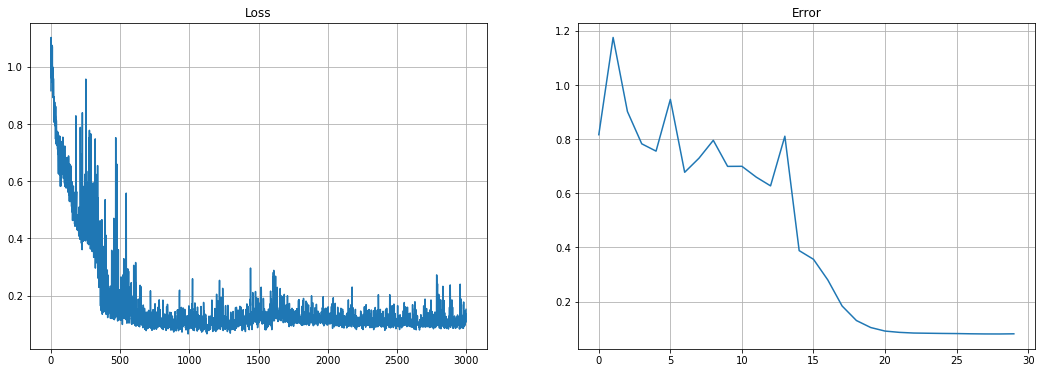

BREAK. There is no improvment for 1000 steps
Best step:  2900
Best Val Error:  0.08066176623106003


In [13]:
loss_history, err_history = [], []
report_frequency = 100
best_err, best_step_err = np.inf, -1
early_stopping_rounds = 1000
lr_decay_steps = 5000
prev_lr_decay_step = 0
max_rounds = -1 # No max round set
max_time = 3600 * 10 # 10 hours

st_time = time.time()
for batch in nodegam.utils.iterate_minibatches(X_train, y_train,
                                               batch_size=batch_size,
                                               shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)

    loss_history.append(float(metrics['loss']))

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.remove_old_temp_checkpoints()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')

        err = trainer.evaluate_mse(X_valid, y_valid, device=device, batch_size=batch_size * 2)
        if err < best_err:
            best_err = err
            best_step_err = trainer.step
            trainer.save_checkpoint(tag='best')
        err_history.append(err)

        trainer.load_checkpoint()  # last

        # Plot loss curve
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(err_history)
        plt.title('Error')
        plt.grid()
        plt.show()

#         if trainer.step == 1:
#             print("Step\tVal_Err\tTime(s)")
#         print('{}\t{}\t{:.0f}'.format(trainer.step, np.around(err, 5), time.time() - st_time))

    if trainer.step > anneal_steps + early_stopping_rounds: # Stop training at least running 4k steps: the steps for temperature annealing
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        break

    if lr_decay_steps > 0 \
            and trainer.step > best_step_err + lr_decay_steps \
            and trainer.step > (prev_lr_decay_step + lr_decay_steps):
        lr_before = trainer.lr
        trainer.decrease_lr(ratio=0.2, min_lr=1e-6)
        prev_lr_decay_step = trainer.step
        print('LR: %.2e -> %.2e' % (lr_before, trainer.lr))

    if 0 < max_rounds < trainer.step:
        print('End. It reaches the maximum rounds %d' % max_rounds)
        break

    if (time.time() - st_time) > max_time:
        print('End. It reaches the maximum run time %d (s)' % max_time)
        break

print("Best step: ", best_step_err)
print("Best Val Error: ", best_err)

In [14]:
max_step = trainer.step
trainer.load_checkpoint(tag='best')
test_err = trainer.evaluate_mse(X_test, y_test, device=device, batch_size=2 * batch_size)

print("Test Error rate: {}".format(test_err))

# Clean up
trainer.remove_old_temp_checkpoints(number_ckpts_to_keep=0)

Test Error rate: 0.08583569526672363


In [15]:
max_step = trainer.step
trainer.load_checkpoint(tag='best')
test_err = trainer.evaluate_mse(X_test, y_test, device=device, batch_size=2 * batch_size)

print("Test Error rate: {}".format(test_err))

# Clean up
trainer.remove_old_temp_checkpoints(number_ckpts_to_keep=0)

Test Error rate: 0.08583569526672363


In [16]:
preprocessor.y_std

181.13719

In [17]:
print("The unnormalized RMSE: {}".format(np.sqrt(test_err * (preprocessor.y_std) ** 2)))

The unnormalized RMSE: 53.069084432669044


Then we visualize this model

In [18]:
os.listdir(f'logs/{name}')

['checkpoint_best.pth', 'checkpoint_avg.pth']

In [19]:
max_n_bins = 256

all_X = pd.concat([data['X_train'], data['X_test']], axis=0)

if max_n_bins is not None and max_n_bins > 0:
    all_X = nodegam.gams.utils.bin_data(all_X, max_n_bins=max_n_bins)

df = model.extract_additive_terms(all_X, norm_fn=preprocessor.transform, y_mu=preprocessor.y_mu, 
                                  y_std=preprocessor.y_std,
                                  device=device, batch_size=2*batch_size)

 26%|██▋       | 20/76 [00:00<00:00, 198.60it/s]

Finish "Run values through model" in 302ms


100%|██████████| 76/76 [00:00<00:00, 201.86it/s]


Finish "Extract values" in 398ms


100%|██████████| 77/77 [00:00<00:00, 1547.37it/s]

Finish "Purify interactions to main effects" in 1.5s
Finish "Center main effects" in 2ms
Finish "Construct table" in 58ms


Here we visualize the main effects

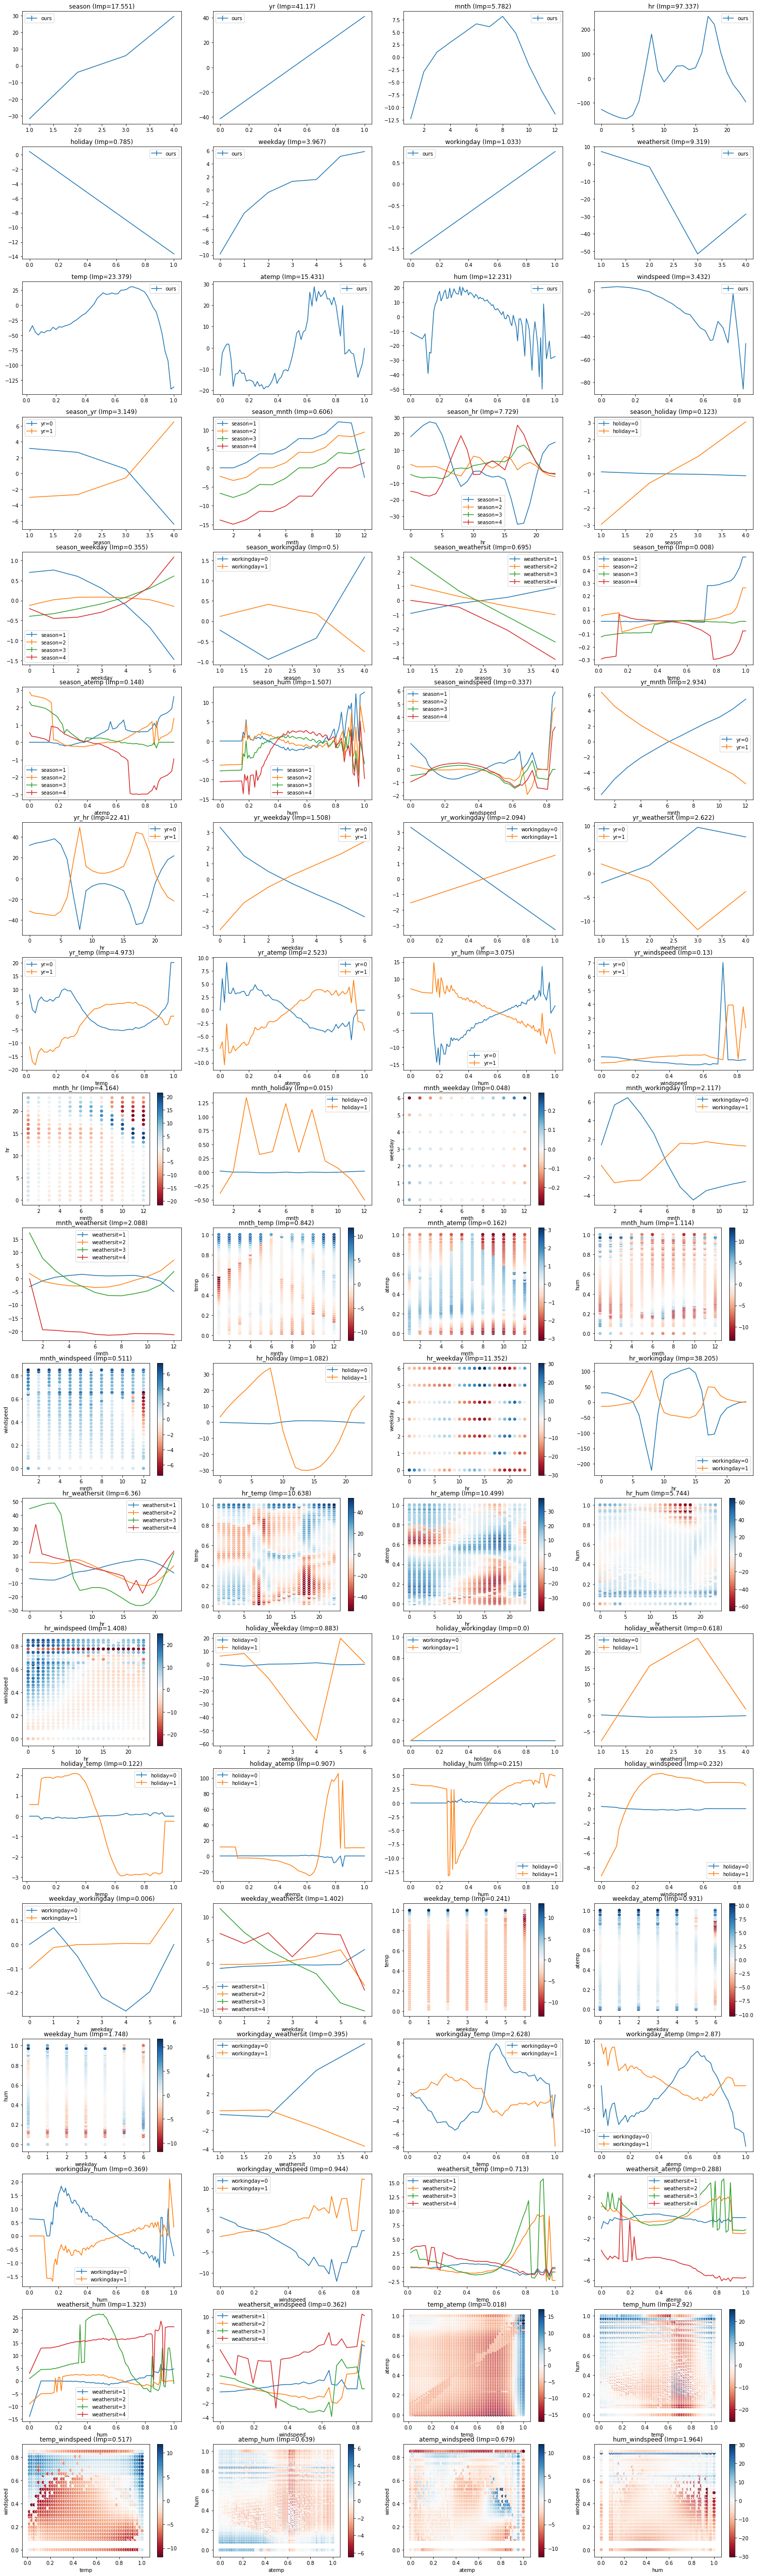

In [20]:
from nodegam.gams import vis_utils
fig, axes = vis_utils.vis_main_effects({'ours': df}, show_density=False)

Top 12 Interaction effects

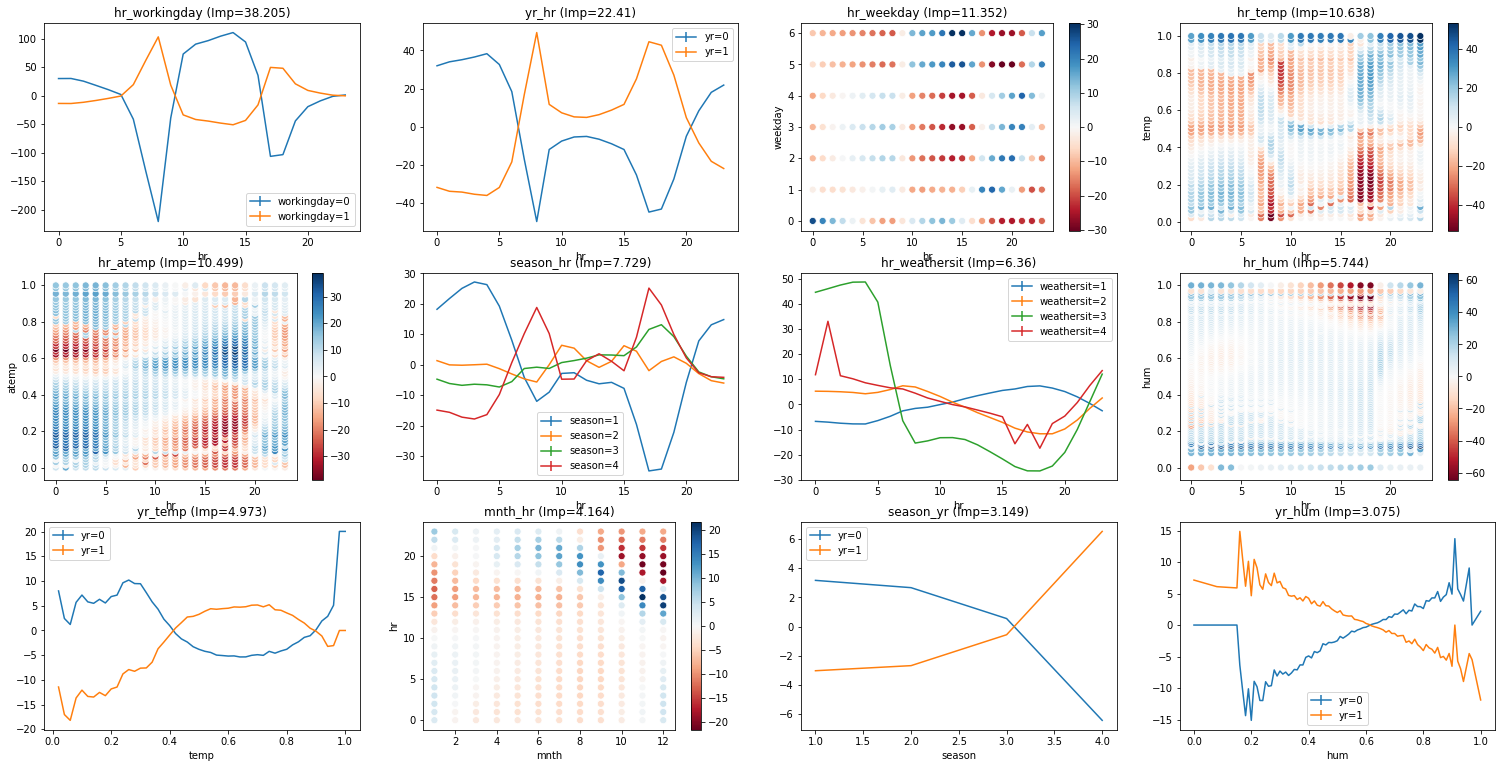

In [21]:
fig, axes = vis_utils.vis_main_effects({'ours': df}, only_interactions=True, top_interactions=12)

Save dataframe

In [22]:
with open('gam_df.pkl', 'wb') as op:
    pickle.dump(df, op, protocol=pickle.HIGHEST_PROTOCOL)